In [152]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import set_config
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import r2_score, mean_absolute_error
from matplotlib import pyplot as plt

In [153]:
# mount GoogleDrive and set the files path
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/NETFLOOX'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NETFLOOX


In [154]:
# Import de la jointure contenant les données des tables title_basics, name.basics et title.ratings
df = pd.read_csv('basics_knownForTitles_ratings.csv', index_col=0)
df

,tconst,primaryTitle,isAdult,decade,runtimeMinutes,genres,nconst,averageRating,numVotes
0,tt0002220,Grannie,0,191.0,NaN,NaN,NaN,4.0,44
1,tt0003589,0-18 or A Message from the Sky,0,191.0,NaN,"Crime,Drama","nm0301187,nm0613115,nm0347532",6.7,42
2,tt0003609,Alexandra,0,191.0,NaN,"Drama,Romance","nm0823150,nm1990343,nm1987804,nm0903959",5.1,13
3,tt0008808,"$5,000 Reward",0,191.0,50.0,Mystery,"nm0267916,nm0516166,nm0429453,nm0761492",5.4,21
4,tt0008810,99,0,191.0,NaN,Crime,"nm0819331,nm0288005,nm13967494",4.4,32
...,...,...,...,...,...,...,...,...,...
286801,tt12801814,Violation,0,202.0,107.0,"Drama,Horror","nm11777181,nm3631020,nm13926845,nm9278354,nm10...",5.3,4044
286802,tt1280685,The Banished,0,199.0,52.0,Documentary,"nm2601444,nm3110629,nm1300389,nm1759159,nm1657917",7.2,43
286803,tt1287896,Daijôbu de aruyô ni: Cocco owaranai tabi,0,200.0,NaN,"Documentary,Music",NaN,5.7,50
286804,tt1291125,Au revoir Taipei,0,201.0,85.0,"Comedy,Crime,Drama","nm11470103,nm2543454,nm6598458,nm6599739,nm094...",6.5,1433


In [155]:
# Vérification que le nombre de 'tconst' est bien unique.
(df.tconst.value_counts() == 1).all()

True

In [156]:
# Sélection des films avec un nombre de votes supérieur à un seuil.
df.query('numVotes >= 250', inplace=True)
df

,tconst,primaryTitle,isAdult,decade,runtimeMinutes,genres,nconst,averageRating,numVotes
7,tt0015145,Monsieur Beaucaire,0,192.0,106.0,"Drama,Romance","nm0909066,nm0948806,nm0497372,nm0245078,nm0401...",6.0,496
9,tt0019286,Storm Over Asia,0,192.0,127.0,"Drama,War","nm0412014,nm0409109,nm0348705,nm0214113,nm2227...",7.0,2188
12,tt0021992,Illicit,0,193.0,79.0,"Drama,Romance","nm0719686,nm1393139,nm1393547,nm1394878,nm1394...",6.1,1062
13,tt0023472,Silver Dollar,0,193.0,83.0,"Biography,Drama,Music","nm0250439,nm0923146,nm0440169",6.3,444
17,tt0026508,I Found Stella Parish,0,193.0,85.0,"Drama,Romance",nm0801209,6.7,523
...,...,...,...,...,...,...,...,...,...
286796,tt1220628,I Hope They Serve Beer in Hell,0,200.0,105.0,Comedy,"nm1910698,nm1901451,nm2056354,nm2103617,nm1924...",5.2,8567
286798,tt1244093,Hisss,0,201.0,98.0,"Comedy,Drama,Horror","nm0816003,nm1335461,nm1324246,nm1997974,nm4147...",2.9,1819
286801,tt12801814,Violation,0,202.0,107.0,"Drama,Horror","nm11777181,nm3631020,nm13926845,nm9278354,nm10...",5.3,4044
286804,tt1291125,Au revoir Taipei,0,201.0,85.0,"Comedy,Crime,Drama","nm11470103,nm2543454,nm6598458,nm6599739,nm094...",6.5,1433


In [157]:
# Exécution du dropna avant de separer y et X
df.dropna(inplace=True)
df.shape

(78243, 9)

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78243 entries, 7 to 286805
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          78243 non-null  object 
 1   primaryTitle    78243 non-null  object 
 2   isAdult         78243 non-null  int64  
 3   decade          78243 non-null  float64
 4   runtimeMinutes  78243 non-null  float64
 5   genres          78243 non-null  object 
 6   nconst          78243 non-null  object 
 7   averageRating   78243 non-null  float64
 8   numVotes        78243 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 6.0+ MB


In [159]:
df.describe()

,isAdult,decade,runtimeMinutes,averageRating,numVotes
count,78243.000000,78243.000000,78243.000000,78243.000000,7.824300e+04
mean,0.001866,199.293253,101.628120,6.015493,1.297382e+04
std,0.043157,2.367342,29.926724,1.258737,6.592877e+04
min,0.000000,189.000000,3.000000,1.000000,2.500000e+02
25%,0.000000,198.000000,89.000000,5.300000,4.560000e+02
50%,0.000000,200.000000,97.000000,6.200000,9.980000e+02
75%,0.000000,201.000000,110.000000,6.900000,3.391000e+03
max,1.000000,202.000000,5220.000000,9.900000,2.697394e+06


In [160]:
# Les films pornographiques sont excessivement minoritaires et représentent une industrie bien à part, donc il vaut mieux les supprimer pour qu'ils ne nuisent pas à la qualité des prédictions.
df.query('isAdult == 0', inplace=True)
df

,tconst,primaryTitle,isAdult,decade,runtimeMinutes,genres,nconst,averageRating,numVotes
7,tt0015145,Monsieur Beaucaire,0,192.0,106.0,"Drama,Romance","nm0909066,nm0948806,nm0497372,nm0245078,nm0401...",6.0,496
9,tt0019286,Storm Over Asia,0,192.0,127.0,"Drama,War","nm0412014,nm0409109,nm0348705,nm0214113,nm2227...",7.0,2188
12,tt0021992,Illicit,0,193.0,79.0,"Drama,Romance","nm0719686,nm1393139,nm1393547,nm1394878,nm1394...",6.1,1062
13,tt0023472,Silver Dollar,0,193.0,83.0,"Biography,Drama,Music","nm0250439,nm0923146,nm0440169",6.3,444
17,tt0026508,I Found Stella Parish,0,193.0,85.0,"Drama,Romance",nm0801209,6.7,523
...,...,...,...,...,...,...,...,...,...
286796,tt1220628,I Hope They Serve Beer in Hell,0,200.0,105.0,Comedy,"nm1910698,nm1901451,nm2056354,nm2103617,nm1924...",5.2,8567
286798,tt1244093,Hisss,0,201.0,98.0,"Comedy,Drama,Horror","nm0816003,nm1335461,nm1324246,nm1997974,nm4147...",2.9,1819
286801,tt12801814,Violation,0,202.0,107.0,"Drama,Horror","nm11777181,nm3631020,nm13926845,nm9278354,nm10...",5.3,4044
286804,tt1291125,Au revoir Taipei,0,201.0,85.0,"Comedy,Crime,Drama","nm11470103,nm2543454,nm6598458,nm6599739,nm094...",6.5,1433


In [161]:
df.iloc[:,0]

7          tt0015145
9          tt0019286
12         tt0021992
13         tt0023472
17         tt0026508
             ...    
286796     tt1220628
286798     tt1244093
286801    tt12801814
286804     tt1291125
286805    tt13000980
Name: tconst, Length: 78097, dtype: object

In [162]:
df.drop(columns=['tconst', 'primaryTitle','isAdult', 'numVotes'], axis=1, inplace=True)
df

,decade,runtimeMinutes,genres,nconst,averageRating
7,192.0,106.0,"Drama,Romance","nm0909066,nm0948806,nm0497372,nm0245078,nm0401...",6.0
9,192.0,127.0,"Drama,War","nm0412014,nm0409109,nm0348705,nm0214113,nm2227...",7.0
12,193.0,79.0,"Drama,Romance","nm0719686,nm1393139,nm1393547,nm1394878,nm1394...",6.1
13,193.0,83.0,"Biography,Drama,Music","nm0250439,nm0923146,nm0440169",6.3
17,193.0,85.0,"Drama,Romance",nm0801209,6.7
...,...,...,...,...,...
286796,200.0,105.0,Comedy,"nm1910698,nm1901451,nm2056354,nm2103617,nm1924...",5.2
286798,201.0,98.0,"Comedy,Drama,Horror","nm0816003,nm1335461,nm1324246,nm1997974,nm4147...",2.9
286801,202.0,107.0,"Drama,Horror","nm11777181,nm3631020,nm13926845,nm9278354,nm10...",5.3
286804,201.0,85.0,"Comedy,Crime,Drama","nm11470103,nm2543454,nm6598458,nm6599739,nm094...",6.5


In [163]:
# Numerical variables
column_num = ['decade', 'runtimeMinutes']
transfo_num = Pipeline(steps=[
    ('scaling', RobustScaler())
])

In [164]:
# Categorical variables
column_tex1 = 'genres'
column_tex2 = 'nconst'
transfo_tex = Pipeline(steps=[
    ('countvec', CountVectorizer(tokenizer=lambda x: x.split(','))), 
    ('dr', TruncatedSVD())    
    ])

In [165]:
# Class ColumnTransformer : apply alls steps on the whole dataset
preparation = ColumnTransformer(
    transformers=[
        ('data_tex1', transfo_tex , column_tex1),
        ('data_tex2', transfo_tex , column_tex2),
        ('data_num', transfo_num , column_num)
    ])

In [166]:
# Declare the pipeline
pipe = Pipeline(steps=[('preparation', preparation),
                        ('model', HistGradientBoostingRegressor())])

In [167]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preparation', 'model', 'preparation__n_jobs', 'preparation__remainder', 'preparation__sparse_threshold', 'preparation__transformer_weights', 'preparation__transformers', 'preparation__verbose', 'preparation__verbose_feature_names_out', 'preparation__data_tex1', 'preparation__data_tex2', 'preparation__data_num', 'preparation__data_tex1__memory', 'preparation__data_tex1__steps', 'preparation__data_tex1__verbose', 'preparation__data_tex1__countvec', 'preparation__data_tex1__dr', 'preparation__data_tex1__countvec__analyzer', 'preparation__data_tex1__countvec__binary', 'preparation__data_tex1__countvec__decode_error', 'preparation__data_tex1__countvec__dtype', 'preparation__data_tex1__countvec__encoding', 'preparation__data_tex1__countvec__input', 'preparation__data_tex1__countvec__lowercase', 'preparation__data_tex1__countvec__max_df', 'preparation__data_tex1__countvec__max_features', 'preparation__data_tex1__countvec__min_df', 'preparation__data_t

In [265]:
# Declare model and parameter for Grid Search
parameters = {'model__learning_rate': [ 0.001, 0.05], 'model__max_iter' : range(160, 190, 10), 'model__max_leaf_nodes': range(100, 110, 10), 'model__max_depth': range(11, 12), 'model__min_samples_leaf' : range(40, 50, 10)}

In [266]:
# Declare the Grid Search method
grid = GridSearchCV(pipe, parameters, scoring=['r2', 'neg_mean_absolute_error'], refit='r2', cv = 3, n_jobs =-1, verbose = 1)

In [267]:
# Display diagram
set_config(display="diagram")
preparation

ColumnTransformer(transformers=[('data_tex1',
                                 Pipeline(steps=[('countvec',
                                                  CountVectorizer(tokenizer=<function <lambda> at 0x7f81ae083ca0>)),
                                                 ('dr', TruncatedSVD())]),
                                 'genres'),
                                ('data_tex2',
                                 Pipeline(steps=[('countvec',
                                                  CountVectorizer(tokenizer=<function <lambda> at 0x7f81ae083ca0>)),
                                                 ('dr', TruncatedSVD())]),
                                 'nconst'),
                                ('data_num',
                                 Pipeline(steps=[('scaling', RobustScaler())]),
                                 ['decade', 'runtimeMinutes'])])

In [268]:
# Fit the model
y = df['averageRating']
X = df.drop(columns='averageRating')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('data_tex1',
                                                                         Pipeline(steps=[('countvec',
                                                                                          CountVectorizer(tokenizer=<function <lambda> at 0x7f81ae083ca0>)),
                                                                                         ('dr',
                                                                                          TruncatedSVD())]),
                                                                         'genres'),
                                                                        ('data_tex2',
                                                                         Pipeline(steps=[('countvec',
                                                                                          CountVectorizer(tokenizer=<function <lambda> at 0x7f81ae083ca0>)),
                                                                                         ('dr',
                                                                                          TruncatedSV...
                                                                                          RobustScaler())]),
                                                                         ['decade',
                                                                          'runtimeMinutes'])])),
                                       ('model',
                                        HistGradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.001, 0.05],
                         'model__max_depth': range(11, 12),
                         'model__max_iter': range(160, 190, 10),
                         'model__max_leaf_nodes': range(100, 110, 10),
                         'model__min_samples_leaf': range(40, 50, 10)},
             refit='r2', scoring=['r2', 'neg_mean_absolute_error'], verbose=1)

In [269]:
# Evaluate cross validation performance 
print("CV score:", grid.best_score_)

CV score: 0.35613092456344964


In [270]:
# Find the best parameters 
print("CV parameters:", grid.best_params_)

CV parameters: {'model__learning_rate': 0.05, 'model__max_depth': 11, 'model__max_iter': 170, 'model__max_leaf_nodes': 100, 'model__min_samples_leaf': 40}


In [271]:
# Make predictions
y_pred = grid.predict(X_test)

In [272]:
# Evaluate model performance
print("R2 score", r2_score(y_test, y_pred))
print("MAE", mean_absolute_error(y_test, y_pred))

R2 score 0.38033956461939344
MAE 0.7469445482113375


Text(0.5, 1.0, 'Distribution Exponentielle de la MAE')

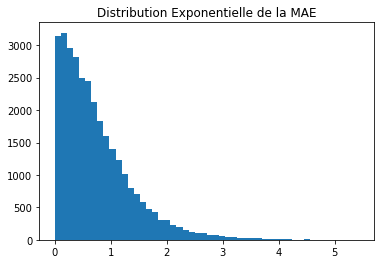

In [273]:
fig1, ax1 = plt.subplots()
err_hist = np.abs(y_test - y_pred)
plt.hist(err_hist, bins=50)
ax1.set_title('Distribution Exponentielle de la MAE')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f80cf360040>,
 'caps': [<matplotlib.lines.Line2D at 0x7f80d165b8b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f80d165b160>],
 'medians': [<matplotlib.lines.Line2D at 0x7f80d165be50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f80ed0f9160>],
 'means': []}

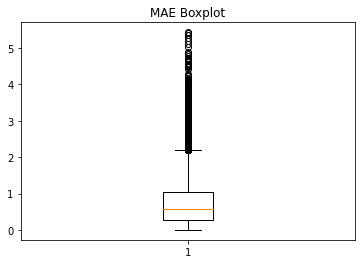

In [274]:
fig1, ax1 = plt.subplots()
ax1.set_title('MAE Boxplot')
ax1.boxplot(err_hist)